<a href="https://colab.research.google.com/github/donskerclass/ComputationalMethodsClass/blob/main/Python/OptimalControlPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optimal Control in Practice


Here are some examples to show implementation of optimal control in Python.

In [1]:
#Libraries for math and plotting
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Lifecycle Problem
We can illustrate using the simplest and most canonical intertemporal optimization problems in economics, the lifecycle savings problem. Here, the only choice is whether to consume now or consume later. You get felicity $u(c)$ from consuming $c$ at any time. You like consuming $u^{\prime}(c)>0$ but have declining marginal utility of consumption $u^{\prime\prime}(c)<0$, and are impatient, discounting future consumption at rate $\rho$. You may invest in assets $A$ (think of these as real capital, like seed corn for a farm) which can be used to produce $f(A)$ at any time, supplemented by fixed wage w. Whetever you do not consume is saved, augmenting $A$. You start at $0.0001$ initial wealth and are required to have assets 0.1 at final time $T$.  
In equations, all of that said you solve

$$\max_{\{c_t\}_{t=0}^T} \int_{0}^{T} e^{-\rho t} u(c) dt $$
$$\text{s.t. } \dot{A} = f(A)+w-c$$
$$A(0)=0.0001, A(T)=0.1$$

The optimality conditions for this are given by Pontryagin's maximum principle. Define the Hamiltonian
$$H(A,c,\lambda,t) = u(c_t) + \lambda_t[f(A_t)+w-c_t]$$
optimality requires
1) Optimization $c=\arg\max_c H$
$$0=\frac{dH}{dc}=u^{\prime}(c)-\lambda$$
2) Costate evolution $\dot{\lambda}=\rho\lambda-\frac{dH}{dA}$
$$\dot{\lambda}=\rho\lambda-\lambda[f^{\prime}(A)]$$
3) Initial condition
$$A(0)=0.0001$$
4) Terminal condition
$$A(T)=0.1$$

Going through some simplifying algebra, this can be rewritten as
$$\dot{c}=\frac{u^{\prime}(c)}{u^{\prime\prime}(c)}(\rho-f^{\prime}(A))$$
$$\dot{A}=f(A)+w-c$$
$$A(0)=0.001, A(T)=0.1$$

We will solve this numerically by shooting. Assume log utility and Cobb Douglas production function $Zk^\alpha$, and some arbitrary other parameters. This turns the equation into
$$\dot{c}=-c\cdot(\rho-\alpha Z(A)^{\alpha-1})$$
$$\dot{A}=ZA^{\alpha}+w-c$$
$$A(0)=A(T)=0$$
Cobb Douglas is great for theory and local approximations but gums up the works for global numerics, because it is undefined for negative capital. This is why we set up the problem so initial and terminal conditions are not 0 but somewhat above it.

In [2]:
Z = 1.0 #Normalization
ρ = 0.03 #Standard
w = 1.0 #Arbitrary
α = 0.33 #Standard

p = (Z, ρ, w, α) #Collect parameters

T = 60.0  #Working periods to retirement 
Ts = [0.0,T] #Lifespan
A0 = 0.0001 #Marginal product not defined if initial wealth is 0 
AT = 0.1 #Must be nonzero for same reason

def lifecycle(t, y, Z = 1.0, ρ = 0.03, w =1.0, α = 0.33):
    y1, y2 = y
    return [-y1 * (ρ - α*Z*(y2)**(α-1)), Z*(y2)**α + w - y1]

In [3]:
#Test it out by solving for arbitrary initial consumption
cguess1 = 0.2
y0 = [cguess1, A0]
guesspath = sp.integrate.solve_ivp(lifecycle,Ts,y0,dense_output=True,method='DOP853')
guesspath

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.270e-03 ...  4.112e+01  6.000e+01]
        y: [[ 2.000e-01  2.147e-01 ...  5.539e-01  3.719e-01]
            [ 1.000e-04  1.214e-03 ...  1.651e+02  2.877e+02]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f005fe94850>
 t_events: None
 y_events: None
     nfev: 212
     njev: 0
      nlu: 0

In [4]:
t = np.linspace(0, T, 300)
guessp = guesspath.sol(t)

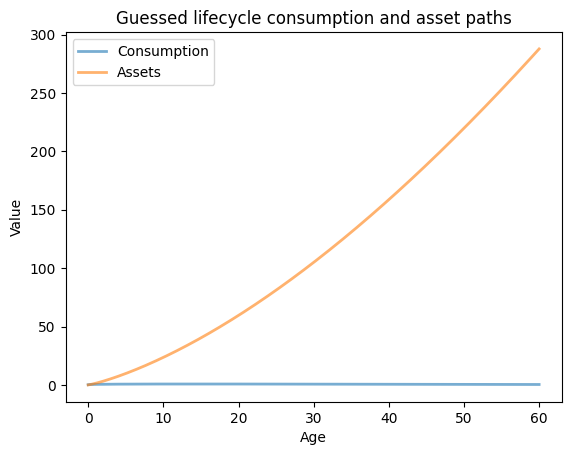

In [5]:
#Plot consumption and assets
fig, ax = plt.subplots()
ax.plot(t, guessp.T, linewidth=2, alpha=0.6)
ax.legend(['Consumption','Assets'])
plt.title('Guessed lifecycle consumption and asset paths')
plt.xlabel('Age')
plt.ylabel('Value')
plt.show()

We see that the above result is not a solution: the agent consumes too little and saves too much, so the terminal condition isn't satisfied.  To code a shooting method, enclose the solver in a function and use a nonlinear equation solver to find the initial condition that gives a solution with the right terminal condition.

In [6]:
guesspath.sol(T)[1] #Assets at end of life

287.6911952279233

In [7]:
def lifecycleshoot(c0, Z = 1.0, ρ = 0.03, w =1.0, α = 0.33,T = T, Ts = [0.0,T], A0 = 0.0001, AT = 0.1):
    y0 = [c0, A0]
    guesspath = sp.integrate.solve_ivp(lifecycle,Ts,y0,dense_output=True,method='DOP853')
    return guesspath.sol(T)[1] - AT

In [8]:
#Verify that the function gives the same answer as above
g2 = lifecycleshoot(cguess1) + 0.1
g2

287.6911952279233

In [9]:
#Find an upper bracket, being aware that negative wealth yields undefined production
upper = 0.34096
gu = lifecycleshoot(upper) #It took a lot of testing to find a number that gave negative output but didn't return an error.
gu

<ipython-input-2-e86ffb018d33>:15: RuntimeWarning: invalid value encountered in double_scalars
  return [-y1 * (ρ - α*Z*(y2)**(α-1)), Z*(y2)**α + w - y1]


-2.6103822960985934e+66

In [10]:
copt = sp.optimize.root_scalar(lifecycleshoot,bracket=[0.2,upper],method='bisect')

<ipython-input-2-e86ffb018d33>:15: RuntimeWarning: invalid value encountered in double_scalars
  return [-y1 * (ρ - α*Z*(y2)**(α-1)), Z*(y2)**α + w - y1]


In [11]:
copt

      converged: True
           flag: 'converged'
 function_calls: 39
     iterations: 37
           root: 0.3409527711327828

In [12]:
#Check result
lifecycleshoot(copt.root)

-1.1707337457811384e-07

That is close to the desired value of 0 in asset space. Finding an upper bracket and a root for this function is generally challenging and prone to numerical issues due to the instability of the ODE solver, which faces exponential growth over long periods. To ensure reasonable accuracy, I ran this with a high order ODE solver: 'Dop853' is an 8th order RK method. You may want to test it with other solvers to ensure accuracy. 

In [13]:
#Now display trajectory
yopt = [copt.root, A0]
optpath = sp.integrate.solve_ivp(lifecycle,Ts,yopt,dense_output=True,method='DOP853')
optpath

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.513e-03 ...  5.990e+01  6.000e+01]
        y: [[ 3.410e-01  3.711e-01 ...  6.934e+00  7.416e+00]
            [ 1.000e-04  1.199e-03 ...  6.172e-01  1.000e-01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f005dd11550>
 t_events: None
 y_events: None
     nfev: 374
     njev: 0
      nlu: 0

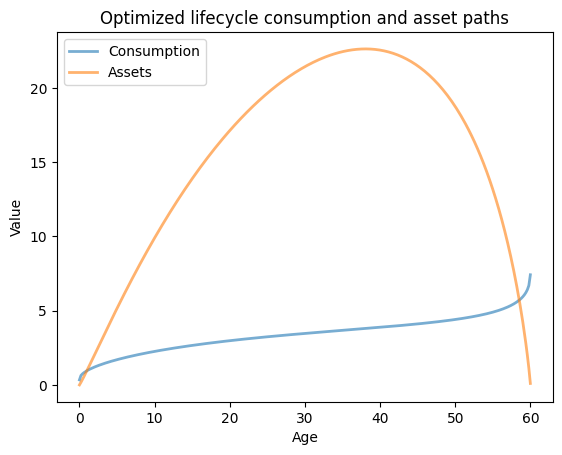

In [14]:
optp=optpath.sol(t)
#Plot consumption and assets
fig, ax = plt.subplots()
ax.plot(t, optp.T, linewidth=2, alpha=0.6)
ax.legend(['Consumption','Assets'])
plt.title('Optimized lifecycle consumption and asset paths')
plt.xlabel('Age')
plt.ylabel('Value')
plt.show()

It can help a lot for qualitative intuition to display problems like this in *phase space*, comparing variables to each other instead of over time.

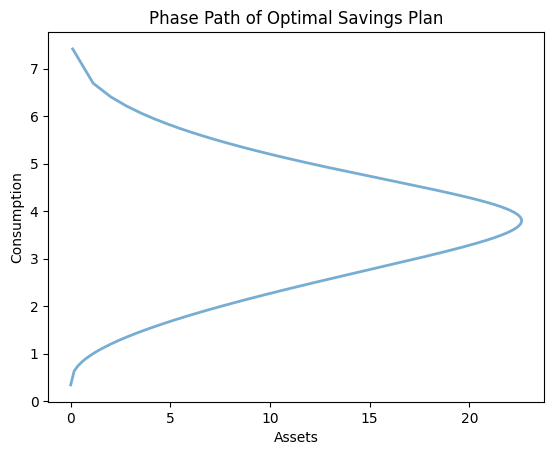

In [15]:
#Plot consumption and assets
fig, ax = plt.subplots()
ax.plot(optp[1,:], optp[0,:], linewidth=2, alpha=0.6)
plt.title('Phase Path of Optimal Savings Plan')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.show()

This displays the qualitative features of an optimal path for a finitely lived agent, viz, a growth in assets and consumption jointly until a midpoint is reached at which the agent starts to decumulate assets, all while continuing to increase consumption, where here, the increasing time path arises from a relatively high patience, relative to the marginal product of assets.

### Infinite Horizon
In the case where the agent is immortal (or equivalently, does not have a known fixed time of death but a random one without fixed bound), you can't simply shoot to the end. One option is to compute a steady state, pretend it is reached in finite but large T, and then forward shoot until you are close. This has the difficulty that the forward system in general optimal control problems is *unstable*, meaning you will get divergence to infinity very quickly for guesses that are above or below the true value. 

In this setting, an alternative bet is *reverse shooting*: start at a steady state, reverse time, and shoot backwards to hit the initial conditions. This has improved stability properties. However, the nontrivial additional issue is that at a steady state, by definition, the time derivative is 0 and so starting at a steady state you stay there. Instead, what you must do is shoot from an initial condition near the steady state, but close enough that the difference is small. In multiple dimensions, you need also to be on the appropriate side of the steady state. A trick here relies on [Stable Manifold Theorem](https://en.wikipedia.org/wiki/Stable_manifold_theorem). Local to the steady state, a stable optimal path is tangent to the direction along which the eigenvalues of the Jacobian of the system have negative real part. Informally, this means that the linearized system provides a good approximation, so you can start at a point on the linearized solution arbitrarily near to the steady state.

For completeness, the revised system is 
1) Optimization $c=\arg\max_c H$
$$0=\frac{dH}{dc}=u^{\prime}(c)-\lambda$$
2) Costate evolution $\dot{\lambda}=\rho\lambda-\frac{dH}{dA}$
$$\dot{\lambda}=\rho\lambda-\lambda[f^{\prime}(A)]$$
3) Initial condition
$$A(0)=0.0001$$
4) Transversality condition
$$\underset{t\to\infty}{\lim}e^{-\rho t}|\lambda(t)A(t)|=0$$

Going through some simplifying algebra, this can be rewritten as
$$\dot{c}=\frac{u^{\prime}(c)}{u^{\prime\prime}(c)}(\rho-f^{\prime}(A))$$
$$\dot{A}=f(A)+w-c$$
$$A(0)=0.0001$$
$$\underset{t\to\infty}{\lim}e^{-\rho t}|u^{\prime}(c(t))A(t)|=0$$

Specializing this to the Cobb Douglas log utility case, have
$$\dot{c}=-c\cdot(\rho-\alpha Z(A)^{\alpha-1})$$
$$\dot{A}=ZA^{\alpha}+w-c$$
$$A(0)=0.0001$$
$$\underset{t\to\infty}{\lim}e^{-\rho t}|u^{\prime}(c(t))A(t)|=0$$

To find the steady state, solve for $\dot{c}=\dot{A}=0$.

In [16]:
def growthout(y, Z = 1.0, ρ = 0.03, w = 1.0, α = 0.33):
    y1, y2 = y
    return -y1 * (ρ - α*Z*(y2)**(α-1)), Z*(y2)**α + w - y1
     

#Test
yinit = 30.0, 4.0
growthout(yinit)

(3.0107044937237175, -27.419917376273247)

In [17]:
#Solve for steady state
steady = sp.optimize.root(growthout,yinit)
steady

 message: The solution converged.
 success: True
  status: 1
     fun: [-6.186e-12  4.388e-13]
       x: [ 4.258e+00  3.584e+01]
    nfev: 24
    fjac: [[-2.551e-01  9.669e-01]
           [-9.669e-01 -2.551e-01]]
       r: [-1.054e+00  3.227e-02  2.436e-03]
     qtf: [ 2.860e-11  8.380e-11]

In [18]:
steadystate = steady.x
steadystate

array([ 4.25780252, 35.83582776])

In [19]:
growthout(steadystate) #Test: is system zero at root?

(-6.186206880868084e-12, 4.3876013933186186e-13)

We can linearize the system around the steady state to describe the behavior in the neighborhood. For this we will use the automatic differentiation capabilities of JAX, since I am too lazy to take a derivative by hand. See the [QuantEcon JAX Intro Tutorial](https://python-programming.quantecon.org/jax_intro.html) for a guide.

In [20]:
import jax
import jax.numpy as jnp

In [21]:
jsteadystate = jnp.array(steadystate) #jnp arrays are like numpy arrays, but play well with autodiff

In [22]:
sjac = jax.jacfwd(growthout)(jsteadystate) #Calculate Jacobian at steady state
sjac

(Array([-0.        , -0.00238816], dtype=float32),
 Array([-1.        ,  0.03000001], dtype=float32))

In [23]:
vals, vecs = np.linalg.eig(sjac)
print(vals)
print(vecs)

[-0.03611911  0.06611911]
[[-0.06597506  0.03609557]
 [-0.9978213  -0.99934834]]


If we push the system along the first eigenvector, corresponding to negative eigenvalue, locally, the system remains close to the true optimal policy.  In other words, for small $h$, $(c^*,k^*)+h\cdot v^1$ is approximately a solution to the system, or $c(k)\approx c^* + \frac{v_1^1}{v_2^1}(k-k^*)$ near steady state.

In [24]:
def clin(k):
  return steadystate[0]+(vecs[0][0]/vecs[1][1])*(k-steadystate[1])

In [25]:
cpt = np.arange(1.2,5.0,0.4)
kpt = np.arange(0.01,50,2.0)

X, Y = np.meshgrid(kpt, cpt)

# Time derivatives at each point
u = -Y * (ρ - α*Z*(X)**(α-1))
v = Z*(X)**(α) + w - Y

In [26]:
#Plot phase diagram with nullclines and approximate stable manifold
kgrid = np.arange(0.00001,50,0.1)
kresgrid = np.arange(0.4,50,0.1)
cgrid = np.arange(1.0,5.0,0.01)

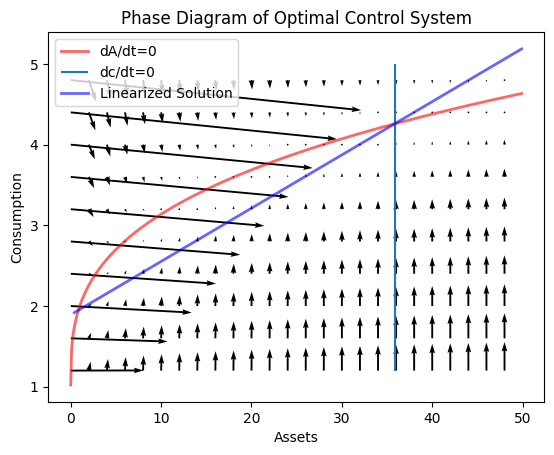

In [27]:
#Plot phase diagram of system
fig, ax = plt.subplots()
ax.plot(kgrid,Z*(kgrid)**(α) + w, 'r', linewidth=2, alpha=0.6, label='dA/dt=0')
ax.vlines(steadystate[1],ymin=1.2,ymax=5.0, label = 'dc/dt=0')
ax.plot(kresgrid,clin(kresgrid), 'b', linewidth=2, alpha=0.6, label = 'Linearized Solution')
ax.legend()
ax.quiver(X,Y,u,v)
plt.title('Phase Diagram of Optimal Control System')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.show()

In [28]:
#Reverse Shooting

h = 0.0001 #distance from steady state capital
kend = steadystate[1]-h 
cnearsteady = clin(kend) #Linearized model's guess of consumption at end

ktarget = 2.0 #Starting capital

def reversepath(t,y,Z = 1.0, ρ = 0.03, w = 1.0, α = 0.33): #time reversed conditions
    y1, y2 = y
    return [y1 * (ρ - α*Z*(y2)**(α-1)), -Z*(y2)**α - w + y1]

T = 355  #Fairly long term: increase if error high 
Tlong = [0.0,T] #truncated interval

#Test it out by solving for arbitrary initial consumption
y0 = [cnearsteady, kend]
reversesol = sp.integrate.solve_ivp(reversepath,Tlong,y0,dense_output=True,method='DOP853')
reversesol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.825e+00  2.007e+01  2.025e+02  3.048e+02
             3.383e+02  3.527e+02  3.550e+02]
        y: [[ 4.258e+00  4.258e+00 ...  1.642e+00  1.257e+00]
            [ 3.584e+01  3.584e+01 ...  4.805e+00  2.328e+00]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f004262ce50>
 t_events: None
 y_events: None
     nfev: 143
     njev: 0
      nlu: 0

In [29]:
t = np.linspace(0, T, 300)
reverseshoot = reversesol.sol(t)

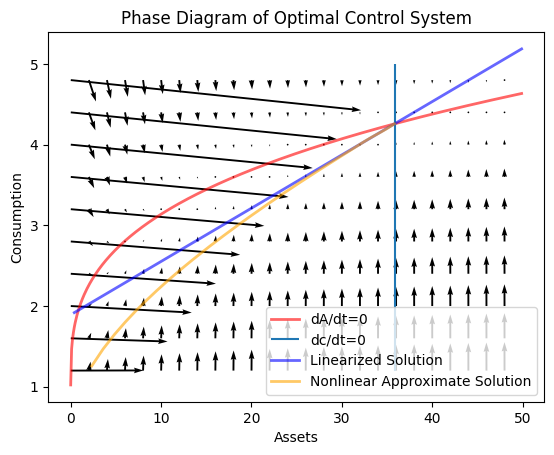

In [30]:
#Plot phase diagram of system
fig, ax = plt.subplots()
ax.plot(kgrid,Z*(kgrid)**(α) + w, 'r', linewidth=2, alpha=0.6, label='dA/dt=0')
ax.vlines(steadystate[1],ymin=1.2,ymax=5.0, label = 'dc/dt=0')
ax.plot(kresgrid,clin(kresgrid), 'b', linewidth=2, alpha=0.6, label = 'Linearized Solution')
ax.plot(reverseshoot[1],reverseshoot[0], 'orange', linewidth=2, alpha=0.6, label = 'Nonlinear Approximate Solution')
ax.legend()
ax.quiver(X,Y,u,v)
plt.title('Phase Diagram of Optimal Control System')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.show()

This could be fine tuned further by moving closer to steady state, or putting inside a reverse shooting loop to tune the c near the steady state. Doing so would require taking a stand on hitting a particular $k_0$ at a particular maximum time $T$. This is a reasonable thing to do if linearization is a challenge and so the guess of $c$ near the steady state is not based on principle.

### Stochastic Problem
In many situations, it makes more sense to work with a model with a random component. This may be because risk is an economically important feature affecting decisions, or can be used to match heterogeneity and deviations from the model as seen in the data. To the above (infinite horizon) problem, consider a situation where assets are risky, which we will model by stochastic depreciation: the asset stock rises or falls in any period according to a square root volatility process. In diffusion notation, the law of motion for assets becomes
$$dA_t=(f(A_t)+w-c_t)dt + \sigma \sqrt{A_t}dW_t$$
equivalently, in stochastic integral notation
$$A(t) = \int_{0}^{t}(f(A(s))+w-c(s))ds + \int_{0}^{t}\sigma \sqrt{A(s)}dW_s$$ 
where the integral is taken in the Ito sense and $W(t)$ is a standard Brownian motion, $W(0)=0$, $W(t+s)-W(t)\sim N(0,s)$ for any $t,s>0$

The optimization problem becomes
$$\max_{\{c_t\}_{t=0}^T} E_0\int_{0}^{\infty} e^{-\rho t} u(c) dt $$
$$\text{s.t. } dA_t=(f(A_t)+w-c_t)dt + \sigma \sqrt{A_t}dW_t$$
$$A(0)=A_0$$

For the stochastic problem, it will be much easier to use a recursive representation. Standard derivations show that the agent's HJB equation takes the form
$$\rho V(A) = \underset{c}{\max}\{u(c)+V^\prime(A)(f(A)+w-c)+\frac{\sigma^2}{2} AV^{\prime\prime}(A)\}$$

Assume again log utility and Cobb-Douglas production. Then the HJB equation can be written as 
$$\rho V(A) = \underset{c}{\max}\{\log(c)+V^\prime(A)(ZA^{\alpha}+w-c)+\frac{\sigma^2}{2} AV^{\prime\prime}(A)\}$$
Taking first order conditions, obtain $\frac{1}{c}=V^\prime(A)$ so $c=(V^\prime(A))^{-1}$. Substituting in, obtain
$$\rho V(A) = -\log(V^\prime(A))+V^\prime(A)(ZA^{\alpha}+w-(V^\prime(A))^{-1})+\frac{\sigma^2}{2} AV^{\prime\prime}(A)$$
Our goal will be to numerically solve this Bellman equation to find the value function $V(A)$, which will then imply a policy function through the optimization rule.

### Methods
The approach will be to follow the finite difference based approach outlined in Ben Moll's notes: see [the technical appendix for the paper](https://benjaminmoll.com/wp-content/uploads/2020/02/HACT_Numerical_Appendix.pdf) and slides on [nonstochastic](https://benjaminmoll.com/wp-content/uploads/2019/07/Lecture3_2149.pdf) and [stochastic](https://benjaminmoll.com/wp-content/uploads/2019/07/Lecture4_2149.pdf) HJB equations. The upshot is that $V(A)$ can be represented on a grid by a vector $\mathbf{v}$, and derivatives by the first and second finite differences. Utility can also be represented on this grid, replacing the derivatives in the optimizer by the corresponding finite difference at the grid point. The discretized HJB equation takes form
$$\rho\mathbf{v} = \mathbf{u}(\mathbf{v}) +M\mathbf{v}$$
where $M$ is a matrix representing the differential operator $(ZA^{\alpha}+w-c)\frac{\partial}{\partial A}+\frac{\sigma^2}{2} A\frac{\partial^2}{\partial A^2}$ applied to $V(A)$ and $\mathbf{u}(\mathbf{v})$ represents utility, with consumption solved out.

Solutions can be found by a continuous analogue of value function iteration. Consider an $n\in[0,\infty]$ representing progress, so $V(A,n)$ is a flow starting at an arbitrary initial guess $V(A,0)$ which converges towards a solution to the HJB equation as $n\to\infty$ according to equation

$$\frac{d}{d n}V(A,n)+\rho V(A,n) = \underset{c}{\max}\{\log(c)+V^\prime(A,n)(ZA^{\alpha}+w-c)+\frac{\sigma^2}{2} AV^{\prime\prime}(A,n)\}$$

Clearly, any solution to the above equation such that $\frac{d}{dn}V(A,n)=0$ solves the original HJB equation. Numerically, we can find this by applying an Euler method to the initial value problem, discretizing in time and space. If the time step is $\Delta$, the explicit Euler equation is

$$\frac{\mathbf{v}^{n+1}-\mathbf{v}^n}{\Delta}+\rho\mathbf{v}^{n} = \mathbf{u}(\mathbf{v}^{n}) +M\mathbf{v}^{n}$$

The implicit Euler update instead takes the form 
$$\frac{\mathbf{v}^{n+1}-\mathbf{v}^n}{\Delta}+\rho\mathbf{v}^{n+1} = \mathbf{u}(\mathbf{v}^{n}) +M\mathbf{v}^{n+1}$$
Rearranging, obtain
$$((\rho+\frac{1}{\Delta})I-M)\mathbf{v}^{n+1}=\mathbf{u}(\mathbf{v}^{n})+\frac{1}{\Delta}\mathbf{v}^n$$
which can be found with a (sparse) linear system solve. The advantage of the implicit method is time steps can be arbitrarily large and still stable, so many fewer updates are needed.

The main thing that makes this approach tricky is that not every discretization scheme has good properties, in terms of guarantees for approximating an optimal solution. Barles and Souganidis laid out a set of sufficient conditions, reviewed in [Moll](https://benjaminmoll.com/wp-content/uploads/2019/07/Lecture3_2149.pdf), the most important of which is for the approximation to be monotone. 

This can be achieved by using a forward difference $v^{\prime}_{i,F}=\frac{v_{i+1}-v_{i}}{\Delta_A}$ when drift of $A$ is positive, and a backward difference $v^{\prime}_{i,B}=\frac{v_{i}-v_{i-1}}{\Delta_A}$ when the drift is negative. Over intervals where drift passes through 0, a central difference $\bar{v}^{\prime}_{i}=\frac{v_{i+1}-v_{i-1}}{2\Delta_A}$ can be used.  Because drift at a grid point itself depends on the derivative, through the FOC, it also may rely on whether forward or backward difference is used.

Here, drift is $s_{i,F}=(A_i^{\alpha}+w-(v^{\prime}_{i,F})^{-1})$ or $s_{i,B}=(A_i^{\alpha}+w-(v^{\prime}_{i,B})^{-1})$. At steady state, drift can be set to 0.

We can then set the derivative at the $i^{th}$ grid point to be given by
$$v^{\prime}_i = v^{\prime}_{i,F}1\{s_{i,F}>0\}+v^{\prime}_{i,B}1\{s_{i,B}<0\}+\bar{v}^{\prime}_{i}1\{s_{i,F}<0<s_{i,B}\}$$
(We can ignore other cases due to concavity which gives a monotone drift function, though see Moll for the non-concave case when FOC do not suffice.)

The second derivative is a little easier, since it is always symmetric: we can use the centered second difference approximation
$$v^{\prime\prime}_i = \frac{v_{i+1}-2v_{i} +v_{i-1}}{\Delta_A^2}$$

Finally, at the boundaries, some restrictions must be imposed, corresponding to the end-point conditions for the spline representation. These should be chosen based on the problem; for example, with borrowing constraints, one may impose a hard boundary of assets at 0, at which derivative may be discontinuous. Alternately, some stochastic processes have reflecting boundaries, where the first derivative is set to 0 at the end points. For representations on a bounded grid of an unbounded process, end point conditions should be such that extrapolation preserves the properties of the value function. In my experience, boundaries which ensure that the second derivative is constant at interior boundaries are useful, as they ensure that concavity is preserved. These all get imposed numerically by adjusting the end conditions of the matrix representing the differential operator, choosing transformations consistent with "ghost nodes" $v_{-1}$, $v_{M+1}$, and so on beyond the grid satisfying the required condition. 

In [31]:
# Parameters: shared ones same as above
ρ = 0.03
α = 0.33
Z = 1.0
w = 1.0
σsq = 0.05
# Grids
Amin = 0.5 #Below steady state
Amax = 65  #Above steady state
ng = 200 #Make this small when testing for speed, large for final run for accuracy
ΔA = (Amax-Amin)/ng
A = np.linspace(Amin,Amax,ng)
#Initial Guess
v0 = np.log(Z*A**α + w)/ρ #Utility of eating current income forever
v = np.log(Z*A**α + w)/ρ
vF = np.zeros_like(v)
vB = np.zeros_like(v)
cons = np.zeros_like(v)
#Algorithm tolerances
maxit = 30
crit = 10**(-6)
ΔN = 100 #time step size
dist = 1000
j = 0; 

In [32]:
while j<maxit and dist>crit:
    vdiff = (v[1:ng] - v[0:(ng-1)])/ΔA
    vdmax = (Z*A[ng-1]**α + w)**(-1)
    vdmin = (Z*A[0]**α + w)**(-1)
    #Forward finite difference: each element uses difference with one in front of it
    vF[0:(ng-1)] = vdiff
    vF[ng-1] = vdmax 
    #Backward finite difference: each element uses difference with one behind it
    vB[1:ng] = vdiff
    vB[0] = vdmin
    #Pad with vdmax and vdmin with understanding that it doesn't get used: just
    #good to have non-0 entry so that everything stays well-defined when inverting

    #Calculate decision and drift using both types of difference
    cF = 1 / vF
    cB = 1 / vB
    driftF = Z*A**α + w - cF
    driftB = Z*A**α + w - cB
    #Calculate consumption when forward drift is not positive and backward drift is not negative 
    #In this case, will use a central difference, and assign as choice the consumption that makes drift 0
    cC = Z*A**α + w
    vC = 1 / cC #ensures c(A)=1/V'(A) holds in this case also
    
    #Choose which difference is used so forward is used if drift positive, backward if negative
    GoF = driftF > 0
    GoB = driftB < 0
    GoC = (1 - GoF - GoB) #Stay in place if neither going forward or backwards
    
    #Combine together to get upwind approximation of V'(k) used for consumption
    vpupwind = vF * GoF + vB * GoB + vC * GoC
    
    cons = 1 / vpupwind #Consumption used for utility function
    util = np.log(cons) #Flow utility of consumption
    
    #Now compute V'(A)*drift using sparse type, which allows fast operations
    #Code uses forward difference if drift positive, backward if negative, central if drift 0
    dfB = -np.minimum(driftB,0.0) / ΔA
    difB = dfB[1:ng]
    dfF = np.maximum(driftF,0.0) / ΔA
    difF = dfF[0:(ng-1)]
    difC = -np.maximum(driftF,0.0) / ΔA + np.minimum(driftB,0.0) / ΔA
    #Amat*v gives the upwind finite difference approximation of the V'(A)*drift
    Amat = sp.sparse.diags([difB,difC,difF],[-1, 0, 1])
    
    #Add second derivative term by second order differences
    #Terms used in numerical representation of second derivative operator
    el = (σsq/(2*ΔA**2))*np.ones(ng-1) 
    ecent = -2*(σsq/(2*ΔA**2))*np.ones(ng)
    er = (σsq/(2*ΔA**2))*np.ones(ng-1) 
    #Auxiliary terms used in boundary condition computations
    er2 = np.zeros(ng-2)
    el2 = np.zeros(ng-2)
    er3 = np.zeros(ng-3)
    el3 = np.zeros(ng-3)
    
    #Set second derivatives at boundary to be equal to linear extrapolation of second derivative one
    # and two grid points up: this ensures continuity of second derivatives
    #Following pattern takes coefficients proportional to [2 -5 4 -1]= 2*[1 -2 1 0]-1*[0 1 -2 1]
    # Times the grid points v_1, v_2, v_3, v_4 or v_m, v_m-1, v_m-2, v_m-3, respectively
    
    #Lower boundary
    er3[0]=-1*σsq/(2*ΔA**2)
    er2[0]=4*σsq/(2*ΔA**2)
    er[0]= -5*(σsq/(2*ΔA**2))
    ecent[0]=2*σsq/(2*ΔA**2)
    #Upper boundary
    el3[ng-4]=-1*σsq/(2*ΔA**2)
    el2[ng-3]=4*σsq/(2*ΔA**2)
    el[ng-2]= -5*(σsq/(2*ΔA**2))
    ecent[ng-1]=2*σsq/(2*ΔA**2)
    #Compute second differences
    diffusemat = sp.sparse.diags([el3,el2,el,ecent,er,er2,er3],[-3,-2,-1,0,1,2,3])

    #Construct implicit update v_next=v_now+step*HJB(v_next) 
    #where HJB(v) = log(c(A))+v'(A)*drift+diffusion(A)*v''(A)-rho*v(A) 
    Bmat = (ρ+1/ΔN)*sp.sparse.eye(ng)-Amat-sp.sparse.diags(A)*diffusemat
    bv = util + v/ΔN
    
    #Solve linear system for implicit update.
    vout=sp.sparse.linalg.spsolve(Bmat,bv)  
    #Since banded matrices used, implicit update nearly as fast as explicit update:
    # implicit method much less sensitive to parameters like step size
    
    dist = max(np.abs(vout - v)) #Calculate size of update
    
    v = vout #Update new guess for next period

    j+=1

In [33]:
#Properties of results
print(f"Stopped in {j} iterations")
print(f"Max value error at convergence: {dist}")

Stopped in 8 iterations
Max value error at convergence: 8.293035662632064e-07


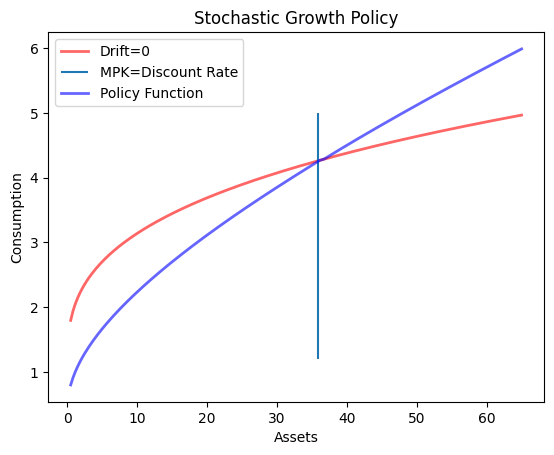

In [34]:
#Plot diagram of system
fig, ax = plt.subplots()
ax.plot(A,Z*(A)**(α) + w, 'r', linewidth=2, alpha=0.6, label='Drift=0')
ax.vlines(steadystate[1],ymin=1.2,ymax=5.0, label = 'MPK=Discount Rate')
ax.plot(A,cons, 'b', linewidth=2, alpha=0.6, label = 'Policy Function')
ax.legend()
plt.title('Stochastic Growth Policy')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.show()

Although it may be hard to see in the plot above, the policy does not intersect the isoclines of the nonstochastic system. Instead, the point at which consumption is set so that the drift in assets equals 0 is at a slightly higher asset level than the level at which the return on assets equals the discount rate, where it was in the nonstochastic setting. With no risk, when the return is equal to the discount rate, consumption stays constant. With risk (and log utility) the saving rate is higher at any given return on capital: this phenomenon is known as "precautionary savings" and is related to but not the same as risk aversion.

#### Simulation

We can generate simulations of implied stochastic growth dynamics using a first order explicit *Euler-Maruyama* scheme, which is equivalent to adding normal shocks at each iteration of a standard Euler scheme. In equations, if we have a diffusion process
$$dx = \mu(x)dt + \sigma(x)dW$$
$$x(0)=x_0$$
the Euler Maruyama scheme with timestep $\Delta t$ starts at $x^0 = x_0$ and then iterates $T/\Delta t$ times
$$x^{n+1} = x^{n}+\mu(x^n)\cdot\Delta t+\sigma(x^n)\sqrt{\Delta t}z^n$$
where $z^n$ are independent $N(0,1)$ random variables. Note the $\sqrt{\Delta t}$ scaling for the shocks reflects the standard deviation over a time step of a Brownian motion.

We use cubic spline interpolation between gridpoints to turn the drift into continuous function, then apply this method. This could also be done using alternate Stochastic Differential Euation solvers: just like for Ordinary Differential Equations, there are methods with differing accuracy and stability properties: Euler-Maruyama is just the simplest to code by hand.

In [35]:
#Simulate Growth Process

duration=100 #Length of simulation
timestep=0.01 #Step size
nsteps= np.floor(duration/timestep).astype(int) #Total number of steps
npaths=5 #How many paths to simulate
initialk=1 #Starting Assets
np.random.seed(100) #Set seed for random number generator
shocks=np.sqrt(timestep)*np.sqrt(σsq)*np.random.randn(nsteps,npaths) #Discretized and scaled Brownian motion
#Note that, per the fact that increments of Brownian motions have variance proportional
#to time step, scaling must be as square root of time step
simpaths=np.zeros((nsteps,npaths))
simpaths[0,:]=initialk*np.ones(npaths) #Start all paths at initial k


driftvec=Z*A**α + w - cons #Optimal drift function at each point of grid 
driftfun=sp.interpolate.CubicSpline(A,driftvec,bc_type='natural') #linear extrapolation at end

In [36]:
#Simulate
for i in range(npaths):
    for t in range(nsteps-1):
        simpaths[t+1,i]=simpaths[t,i]+driftfun(simpaths[t,i])*timestep+np.sqrt(simpaths[t,i])*shocks[t,i]

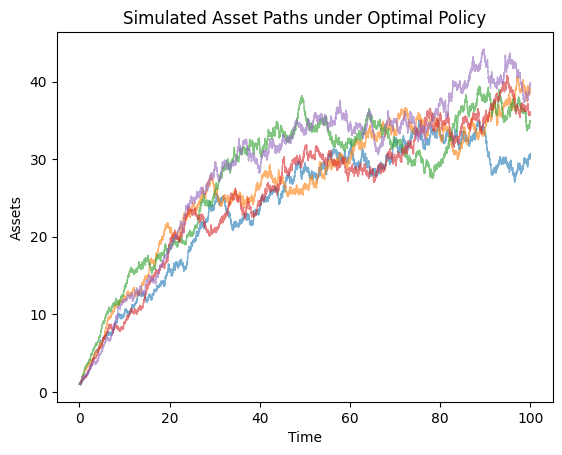

In [37]:
tgrid=np.arange(0,duration,timestep) #Time points

#Plot simulations.T
fig, ax = plt.subplots()
ax.plot(tgrid,simpaths, linewidth=1, alpha=0.6)
plt.title('Simulated Asset Paths under Optimal Policy')
plt.xlabel('Time')
plt.ylabel('Assets')
plt.show()